In [453]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [454]:
df = pd.read_csv(os.path.join('data','titanic.csv'))
# df = pd.read_csv(os.path.join('data','kaggle_train.csv'))
# df = pd.read_csv(os.path.join('data','kaggle_test.csv'))

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   float64
 1   Pclass    1309 non-null   float64
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   float64
 6   Parch     1309 non-null   float64
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(6), object(5)
memory usage: 112.6+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.381971,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.486055,0.837836,14.413500,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [455]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3.0,"Boulos, Mr. Hanna",male,NaN,0.0,0.0,2664,7.2250,NaN,C
1,1.0,3.0,"de Mulder, Mr. Theodore",male,30.0,0.0,0.0,345774,9.5000,NaN,S
2,0.0,2.0,"Banfield, Mr. Frederick James",male,28.0,0.0,0.0,C.A./SOTON 34068,10.5000,NaN,S
3,0.0,2.0,"Eitemiller, Mr. George Floyd",male,23.0,0.0,0.0,29751,13.0000,NaN,S
4,1.0,1.0,"Longley, Miss. Gretchen Fiske",female,21.0,0.0,0.0,13502,77.9583,D9,S


## Missing Values

In [456]:
null = df.isnull().sum().sort_values(ascending=False)
percentage_of_null = round(null/df.isnull().count()*100,2)

pd.concat([null,percentage_of_null],axis=1,keys=['Total','Missing %'])


,Total,Missing %
Cabin,1014,77.46
Age,263,20.09
Embarked,2,0.15
Fare,1,0.08
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00


### What is the highest age group that survived?

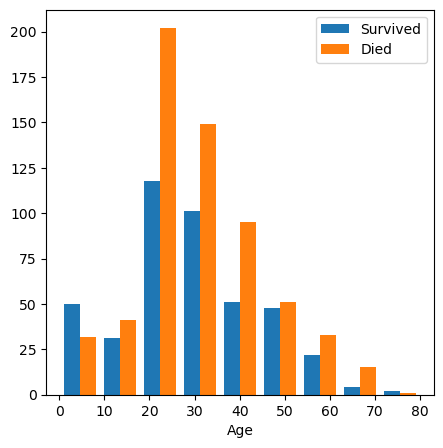

In [457]:
try:
    survived = df[df['Survived']==1].Age
    died     = df[df['Survived']==0].Age

    plt.hist([survived,died], bins=9,label=['Survived','Died'])
    plt.rcParams["figure.figsize"] = (5,5)

    plt.xlabel("Age")
    plt.legend(labels=['Survived','Died'])

    plt.show()
except Exception as e:
    print('Skipping...')

### Comparing the surival rate of men and women

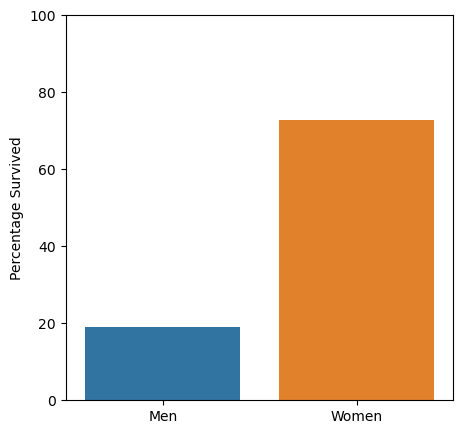

In [458]:
try:
    men   = df[df['Sex']=='male']
    women = df[df['Sex']=='female']

    rate_m = len(men[men['Survived']==1]) / len(men.Survived)
    rate_f = len(women[women['Survived']==1]) / len(women.Survived)

    plt.ylim(0,100)
    plt.ylabel("Percentage Survived")
    sns.barplot(["Men","Women"],[rate_m*100,rate_f*100])
    plt.show()
except Exception as e:
    print('Skipping...')

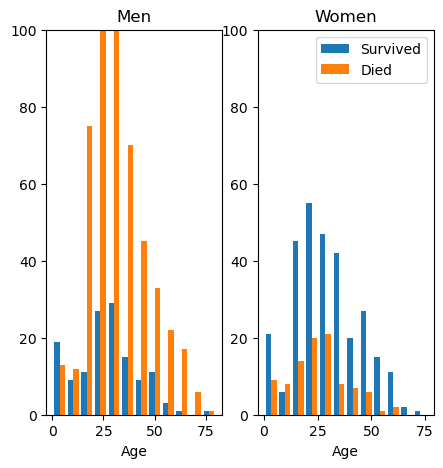

In [459]:
try:

    bins = 12

    men   = df[df['Sex']=='male']
    women = df[df['Sex']=='female']

    survived_m = men[men['Survived']==1].Age
    died_m     = men[men['Survived']==0].Age

    survived_f = women[women['Survived']==1].Age
    died_f     = women[women['Survived']==0].Age


    plt.subplot(1,2,1)
    plt.ylim(0,100)
    plt.title('Men')
    plt.xlabel("Age")
    plt.hist([survived_m,died_m], bins=bins,label=['Survived','Died'])

    plt.subplot(1,2,2)
    plt.ylim(0,100)
    plt.title('Women')
    plt.xlabel("Age")
    plt.hist([survived_f,died_f], bins=bins,label=['Survived','Died'])


    plt.legend(labels=['Survived','Died'])

    plt.show()
except Exception as e:
    print('Skipping...')

### Viewing Correlations between variables

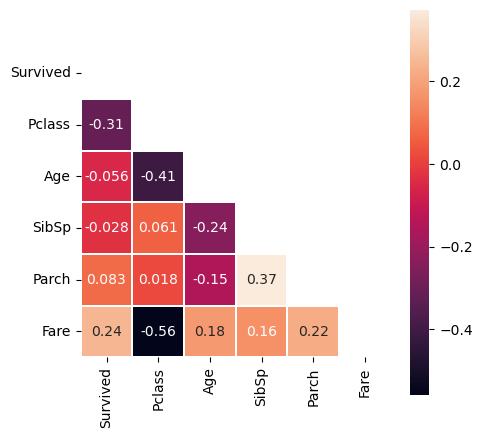

In [460]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, linewidth=0.3, annot=True, square=True,
           mask=mask)
plt.show()

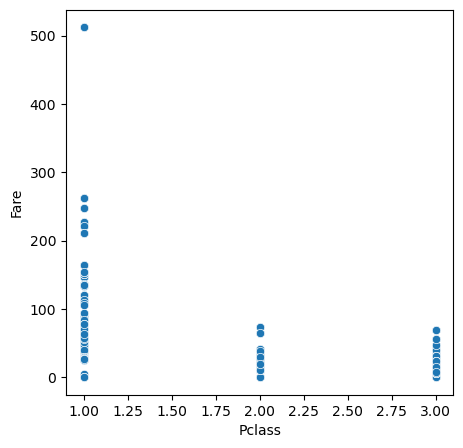

In [461]:
sns.scatterplot(df['Pclass'],df['Fare'])
plt.show()

Although Pclass is correlated with Fare with a value of -0.55, it doesn't make sense to remove on of the features. From the above scatter plot we can see that if a person paid less than 100, then it is unclear which Pclass he belongs to. 

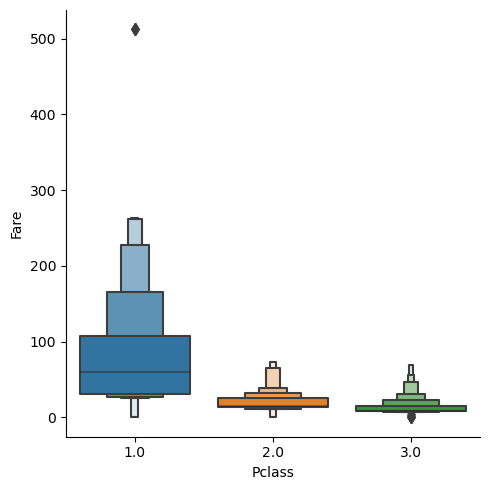

In [462]:
sns.catplot(x="Pclass", y="Fare", data=df, kind="boxen")
plt.show()

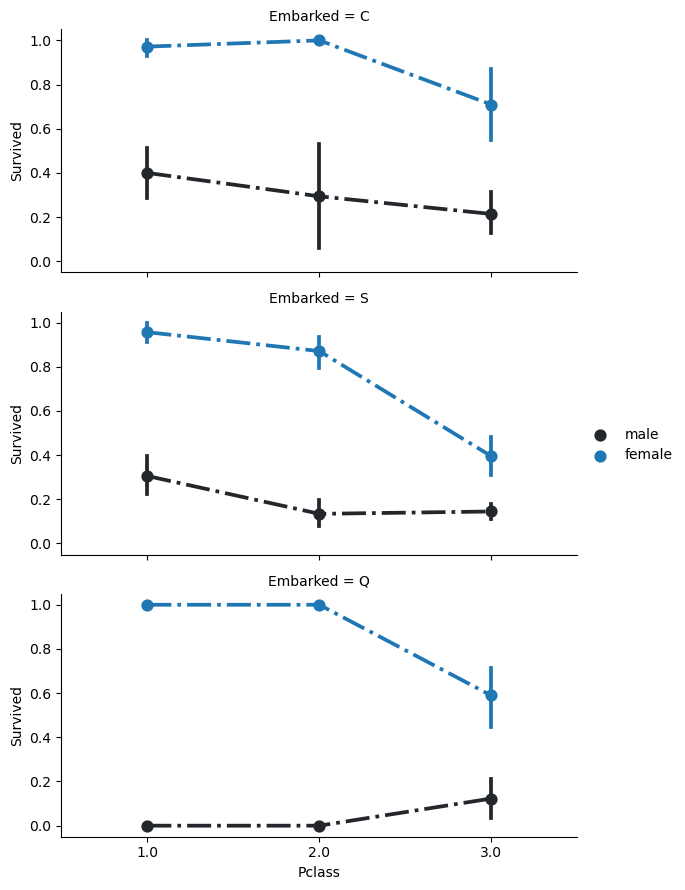

In [463]:
try:
    FacetGrid = sns.FacetGrid(df, row='Embarked', aspect=2)
    FacetGrid.map(sns.pointplot, 'Pclass', 'Survived','Sex',
                  linestyles = '-.')
    FacetGrid.add_legend()
    plt.show()
except Exception as e:
    print('Skipping...')


From the above pointplots, we can see that embarking from Port Q has the worst survival chances for males,
but the best for women. Embarking from Port C gives the best chances of survival for men, but the worst for women. 
Pclass 3 seems to be the worst option. Survival rate always dips for both men and women, except for a slight increase for men who embarked from Port Q.

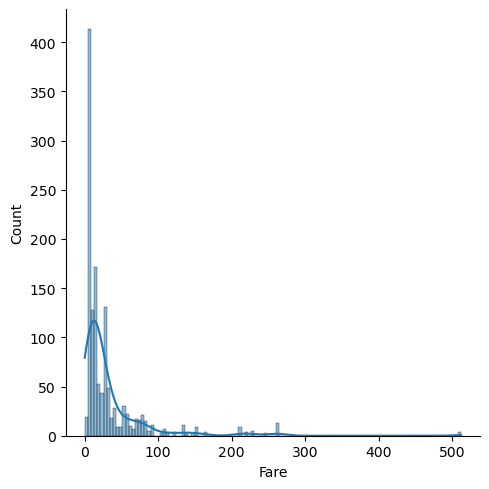

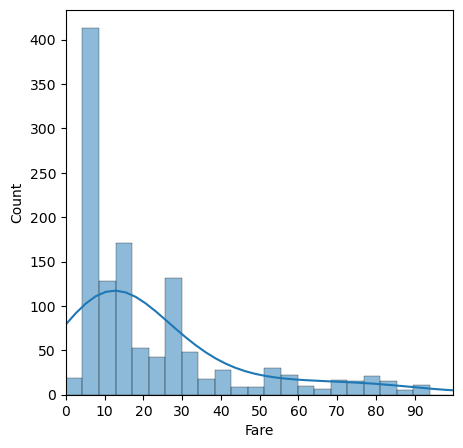

In [464]:
#Plot survival rate and Fare. Bin Fare into discrete groups
sns.displot(df["Fare"], kde=True)
plt.show()

fig,ax = plt.subplots()
sns.histplot(df["Fare"], kde=True, ax=ax)

ax.set_xlim(0,100)
ax.set_xticks(range(0,100,10))
plt.show()

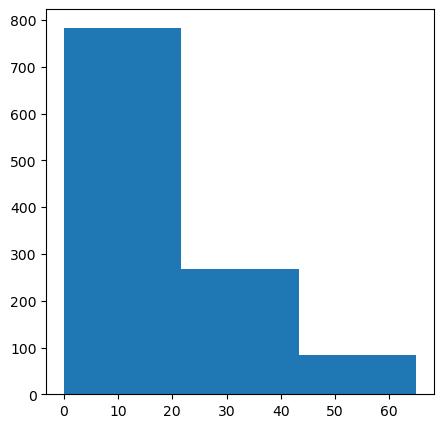

In [465]:
#Remove outliers to calculate bin ranges
Q1 = df['Fare'].quantile(0.25) 
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1

fare_categories = df['Fare'][~((df['Fare'] < (Q1 - 1.5 * IQR)) |(df['Fare'] > (Q3 + 1.5 * IQR)))]

ranges = plt.hist(fare_categories, bins=3)[1]
plt.show()

In [466]:
ranges[3] = float('inf') #Anything greater than the 2nd bin is in the 3rd bin.
ranges

array([ 0.        , 21.66666667, 43.33333333,         inf])

In [467]:
df['Fare_Category'] = pd.cut(df['Fare'], bins=ranges, labels=['Low','Mid','High'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Category
0,0.0,3.0,"Boulos, Mr. Hanna",male,NaN,0.0,0.0,2664,7.2250,NaN,C,Low
1,1.0,3.0,"de Mulder, Mr. Theodore",male,30.0,0.0,0.0,345774,9.5000,NaN,S,Low
2,0.0,2.0,"Banfield, Mr. Frederick James",male,28.0,0.0,0.0,C.A./SOTON 34068,10.5000,NaN,S,Low
3,0.0,2.0,"Eitemiller, Mr. George Floyd",male,23.0,0.0,0.0,29751,13.0000,NaN,S,Low
4,1.0,1.0,"Longley, Miss. Gretchen Fiske",female,21.0,0.0,0.0,13502,77.9583,D9,S,High


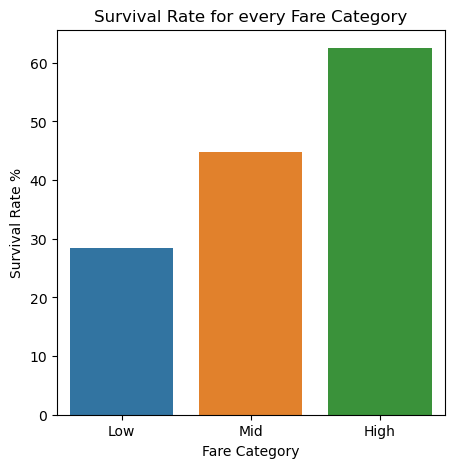

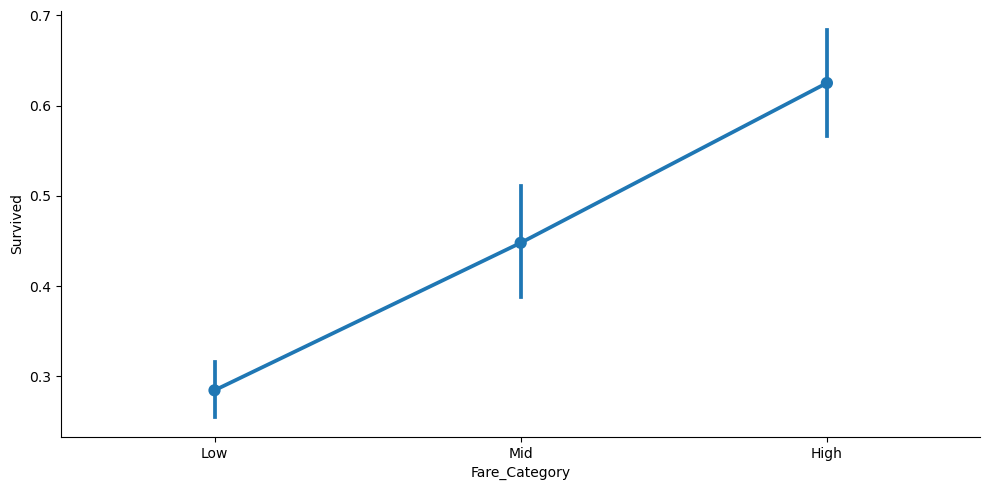

In [468]:
try:

    low  = df[df["Fare_Category"] == "Low"]
    mid  = df[df["Fare_Category"] == "Mid"]
    high = df[df["Fare_Category"] == "High"]

    low_survived = low[low["Survived"] == 1].Survived.count()/low.Survived.count() * 100
    mid_survived = mid[mid["Survived"] == 1].Survived.count()/mid.Survived.count() * 100
    high_survived = high[high["Survived"] == 1].Survived.count()/high.Survived.count() * 100

    fig,ax = plt.subplots()

    plt.title('Survival Rate for every Fare Category')
    plt.xlabel("Fare Category")
    plt.ylabel("Survival Rate %")

    sns.barplot(x=["Low","Mid","High"], y=[low_survived,mid_survived,high_survived])
    sns.factorplot("Fare_Category", "Survived", data=df, aspect=2)
    plt.show()
except Exception as e:
    print('Skipping...')


It seems that the fare is positively correlated with your chances of survival. We have seen that passengers who paid more where more likely to belong to Pclass 1. Moreover, we know that Pclass 1 <i>tends</i> to have the highest survival rate across all values of Embarked & Sex. So this conclusion makes sense.

### Does being with your family affect your chances of survival? 

In [469]:
df['Family'] = df['SibSp']+df['Parch']

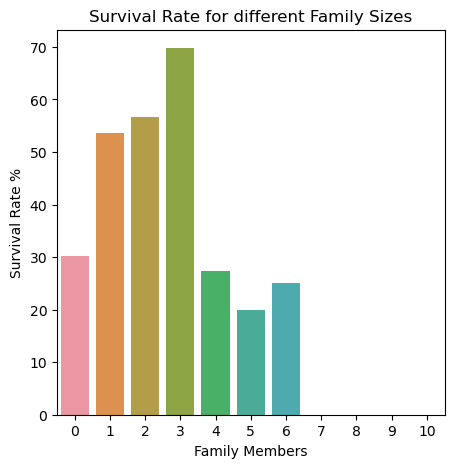

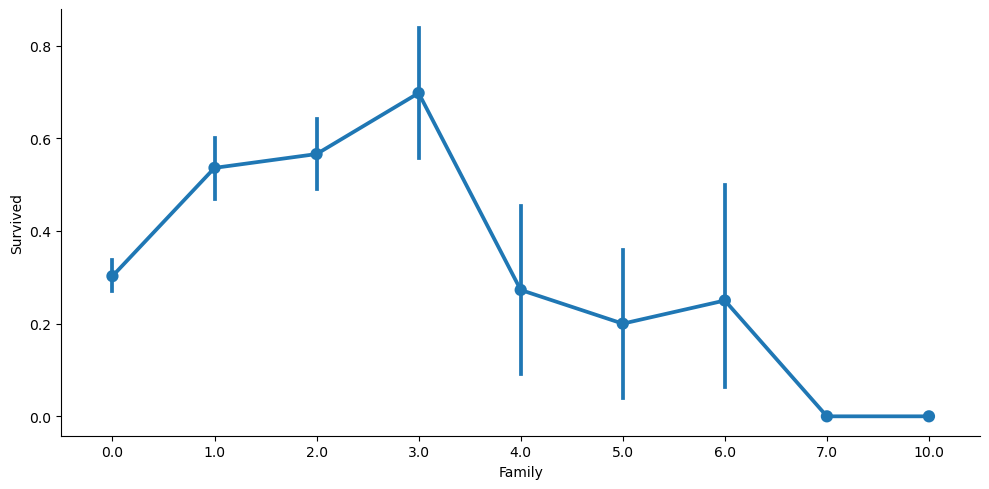

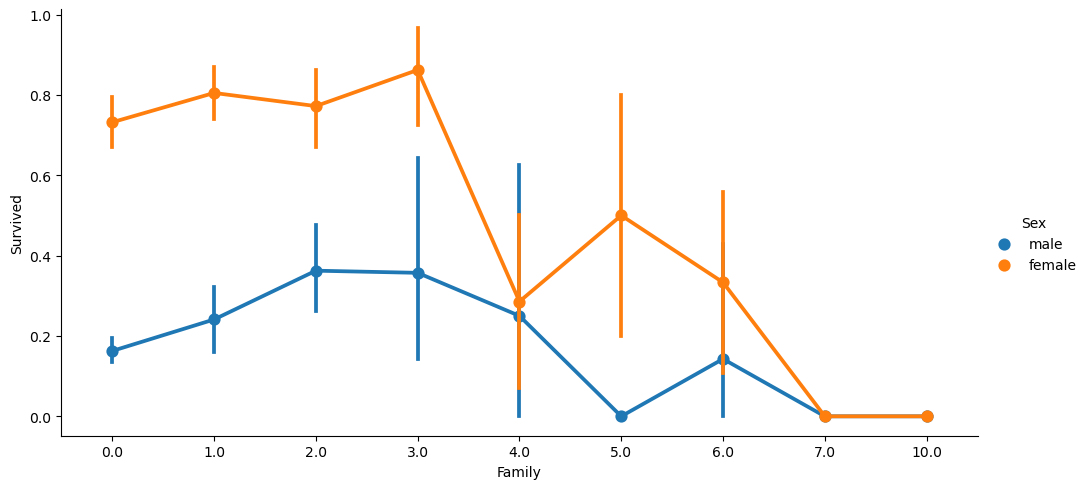

In [470]:
try:
    max = int(df["Family"].max()+1)
    arr = [None]*max

    family = pd.DataFrame()

    for i in range(max):
        survived = len(df[(df["Family"]==i) & (df["Survived"]==1)])
        total = len(df[df["Family"]==i])

        arr[i] = survived/total * 100 if total > 0 else 0

    fig,ax = plt.subplots()

    plt.title('Survival Rate for different Family Sizes')
    plt.xlabel("Family Members")
    plt.ylabel("Survival Rate %")

    sns.barplot(x=[i for i in range(max)], y=arr)
    sns.factorplot('Family', 'Survived', data=df, aspect=2)
    sns.factorplot('Family', 'Survived', data=df, aspect=2, hue="Sex")
    plt.show()
except Exception as e:
    print('Skipping...')

From the above graphs we can infer that having 3 family members gives the highest chances of survival, for both men and women. Going forward, I will remove SibSp and Parch from the dataset since Family will make up for them.

In [471]:
df = df.drop(columns=['SibSp', 'Parch'])
df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Fare_Category,Family
0,0.0,3.0,"Boulos, Mr. Hanna",male,NaN,2664,7.2250,NaN,C,Low,0.0
1,1.0,3.0,"de Mulder, Mr. Theodore",male,30.0,345774,9.5000,NaN,S,Low,0.0
2,0.0,2.0,"Banfield, Mr. Frederick James",male,28.0,C.A./SOTON 34068,10.5000,NaN,S,Low,0.0
3,0.0,2.0,"Eitemiller, Mr. George Floyd",male,23.0,29751,13.0000,NaN,S,Low,0.0
4,1.0,1.0,"Longley, Miss. Gretchen Fiske",female,21.0,13502,77.9583,D9,S,High,0.0


Moreover PassengerId and Ticket won't be useful in our prediction, so we can remove that aswell. We have binned Fare into 3 discrete groups, so we can remove it aswell.

## Final cleaning

### Imputing Age

In [472]:
#Impute Age missing values by getting the average age for that person's Sex, Pclass and Survived value.

df['Age'] = df['Age'].fillna(df.groupby(['Sex','Pclass'])['Age'].transform('mean'))

In [473]:
df[df.Age.isna()]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Fare_Category,Family


### Removing Embarked NA values

In [474]:
df = df.dropna(subset=['Embarked'])
df.Embarked.isna().sum()

0

### Removing features

In [475]:
df = df.drop(['Ticket', 'Fare', 'Cabin', 'Name'],axis=1)

#PassengerId is only found in the Kaggle dataset.
try: df = df.drop(columns=['PassengerId']) 
except Exception as e: pass

df.head()

,Survived,Pclass,Sex,Age,Embarked,Fare_Category,Family
0,0.0,3.0,male,25.962273,C,Low,0.0
1,1.0,3.0,male,30.000000,S,Low,0.0
2,0.0,2.0,male,28.000000,S,Low,0.0
3,0.0,2.0,male,23.000000,S,Low,0.0
4,1.0,1.0,female,21.000000,S,High,0.0


### Constraining float values to be integers

In [476]:
df['Age'] = df['Age'].round(0).astype(int)
df['Family'] = df['Family'].round(0).astype(int)
df['Pclass'] = df['Pclass'].round(0).astype(int)

In [477]:
try:
    df['Survived'] = df['Survived'].round(0).astype(int)
except Exception as e:
    print('Skipping...')

### Turning categorical values into numbers

In [478]:
df['Sex'] = df['Sex'].replace(['male','female'],[0,1])
df['Embarked'] = df['Embarked'].replace(['C','S','Q'],[0,1,2])
df['Fare_Category'] = df['Fare_Category'].replace(['Low','Mid','High'],[0,1,2])

### One-hot encoding categorical variables

In [479]:
#PClass
one_hot_Pclass = pd.get_dummies(df.Pclass)
one_hot_Pclass.columns =['Pclass_1','Pclass_2','Pclass_3']
one_hot_Pclass = one_hot_Pclass.drop(['Pclass_3'],axis=1)

#Embarked
one_hot_Embarked = pd.get_dummies(df.Embarked)
one_hot_Embarked.columns =['Embarked_1','Embarked_2','Embarked_3']
one_hot_Embarked = one_hot_Embarked.drop(['Embarked_3'],axis=1)

# #Fare_Category
one_hot_Fare_Category = pd.get_dummies(df.Fare_Category)
one_hot_Fare_Category.columns =['Fare_Category_1','Fare_Category_2','Fare_Category_3']
one_hot_Fare_Category = one_hot_Fare_Category.drop(['Fare_Category_3'],axis=1)

df = pd.concat([df,one_hot_Pclass, one_hot_Embarked, one_hot_Fare_Category],axis=1).drop(['Pclass','Embarked','Fare_Category'],axis=1)

df

,Survived,Sex,Age,Family,Pclass_1,Pclass_2,Embarked_1,Embarked_2,Fare_Category_1,Fare_Category_2
0,0,0,26,0,0,0,1,0,1,0
1,1,0,30,0,0,0,0,1,1,0
2,0,0,28,0,0,1,0,1,1,0
3,0,0,23,0,0,1,0,1,1,0
4,1,1,21,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1304,1,1,40,0,1,0,0,1,0,0
1305,0,0,26,0,0,0,0,0,1,0
1306,1,1,24,5,0,1,0,1,1,0
1307,1,0,23,1,1,0,1,0,0,0


### Saving

The feature-engineered dataset will be split into training and testing partitions.

In [480]:
# df.to_csv(os.path.join('data','titanic_cleaned.csv'), index=False)
# df.to_csv(os.path.join('data','kaggle_train_cleaned.csv'), index=False)
df.to_csv(os.path.join('data','kaggle_test_cleaned.csv'), index=False)